In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [13]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # hidden_size = 10
        # set this so low to ensure we are not
        # compute-bound by the linear layer
        # this is only an issue when running on CPU,
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
            self,
            x: torch.Tensor, # (batch_size, seq_len, features)
            loras_a: torch.Tensor, # (num_loras, in_features, out_features)
            loras_b: torch.Tensor, # (num_loras, out_features, in_features)
            lora_indices: torch.LongTensor, # (batch_size,)
        ) -> torch.Tensor:
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

In [14]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
            self,
            x: torch.Tensor, # (batch_size, seq_len, features)
            loras_a: torch.Tensor, # (num_loras, in_features, out_features)
            loras_b: torch.Tensor,
            lora_indices: torch.LongTensor, # (batch_size,)
        ) -> torch.Tensor:
        y = self.linear(x)
        for batch_index, lora_index in enumerate(lora_indices):
            lora_a = loras_a[lora_index]
            lora_b = loras_b[lora_index]
            y[batch_index] += x[batch_index] @ lora_a @ lora_b
        return y



In [15]:
# toy example of a detokenizer. The vocabulary only consists of 10 words (different colors)
detokenizer = ['red', 'green', 'blue', 'yellow', 'black', 'white', 'purple', 'orange', 'pink', 'brown']

In [16]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [17]:
torch.manual_seed(42)

In [18]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [19]:
model = LoopMultiLoraModel()

In [20]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iterration
    lora_indices = torch.randint(num_loras, (bs, ), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids = input_ids,
        loras_a = loras_a,
        loras_b = loras_b,
        lora_indices = lora_indices,
    )
    print(next_token)

['green']
['red']
['brown']
['blue']
['pink']
['blue']
['red']
['green']
['purple']
['red']


In [21]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64

def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size,
                (bs, seq_len),
                dtype=torch.long,
            )
            lora_indices = torch.randint(
                num_loras, (bs, ), dtype=torch.long
            )

            # measure the end-to-end latency for
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies


In [22]:
avg_latencies_loop = benchmark(model)

1 4.006385803222656e-05
2 4.246616363525391e-05
3 4.7069549560546877e-05
4 5.512571334838867e-05
5 6.333398818969726e-05
6 7.223749160766601e-05
7 7.87053108215332e-05
8 8.775615692138672e-05
9 9.613227844238282e-05
10 0.0001082601547241211
11 0.00010964107513427734
12 0.00012347221374511719
13 0.00012713623046875
14 0.00013376903533935546
15 0.00014149999618530274
16 0.00015014171600341797
17 0.00015889167785644533
18 0.0001640753746032715
19 0.00018021202087402345
20 0.0001906604766845703
21 0.00019137191772460938
22 0.00019594097137451172
23 0.00020711231231689453
24 0.00021252155303955078
25 0.00022061395645141602
26 0.00022520685195922852
27 0.0002430562973022461
28 0.00024422645568847654
29 0.00025064897537231445
30 0.00025484323501586916
31 0.0002643575668334961
32 0.0002784514427185059
33 0.000286135196685791
34 0.00028821802139282227
35 0.00029563474655151366
36 0.0003070321083068848
37 0.00031648588180541995
38 0.00031835412979125974
39 0.0003376679420471191
40 0.000337022781

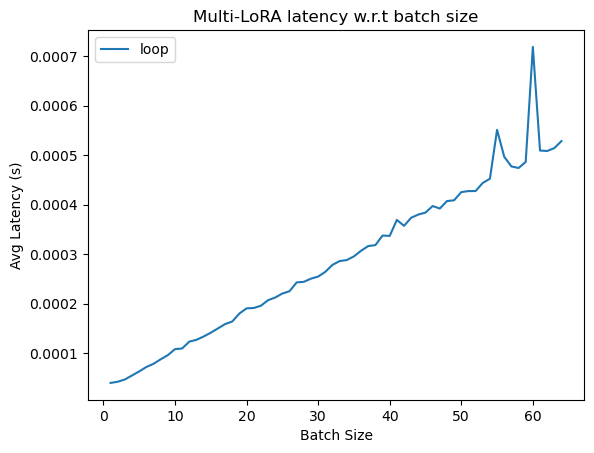

In [24]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t batch size')
plt.legend()

plt.show()

In [25]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
            self,
            x: torch.Tensor,
            loras_a: torch.Tensor,
            loras_b: torch.Tensor,
            lora_indices: torch.LongTensor,
        ) -> torch.Tensor:
            y = self.linear(x)

            # gather the LoRA weights into a new tensor and apply
            lora_a = torch.index_select(loras_a, 0, lora_indices)
            lora_b = torch.index_select(loras_b, 0, lora_indices)
            y += x @ lora_a @ lora_b
            return y

In [26]:
model = GatheredMultiLoraModel()

In [27]:
avg_latencies_gather = benchmark(model)

1 4.984712600708008e-05
2 3.5380363464355466e-05
3 3.541231155395508e-05
4 3.6295890808105466e-05
5 3.7399768829345706e-05
6 3.8881301879882815e-05
7 4.153680801391601e-05
8 4.1898250579833986e-05
9 4.344034194946289e-05
10 4.511308670043945e-05
11 4.945993423461914e-05
12 4.724407196044922e-05
13 5.007028579711914e-05
14 5.306529998779297e-05
15 5.400991439819336e-05
16 5.267572402954101e-05
17 6.858491897583008e-05
18 5.975866317749023e-05
19 5.885410308837891e-05
20 6.081962585449219e-05
21 6.151342391967773e-05
22 6.300640106201171e-05
23 6.28190040588379e-05
24 6.376457214355468e-05
25 6.569671630859375e-05
26 6.821775436401367e-05
27 6.700038909912109e-05
28 6.821250915527343e-05
29 6.855583190917968e-05
30 7.084274291992188e-05
31 7.306814193725587e-05
32 7.484483718872071e-05
33 7.504940032958984e-05
34 7.46779441833496e-05
35 7.563257217407227e-05
36 7.782888412475586e-05
37 8.278179168701172e-05
38 8.298349380493164e-05
39 8.219718933105469e-05
40 8.215808868408203e-05
41 8.1

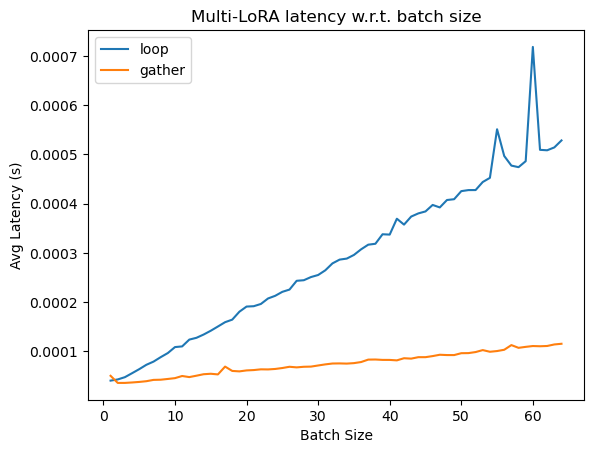

In [28]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gather, label="gather")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()